<img src="../images/logo.png" alt="slb" style= "width: 1700px"/>

# ⚡️   - Facies Modelling Using Machine Learning

The objective of this exercise is to utilize data from vertical wells in order to create a machine learning model that can predict facies on the seismic cube. To achieve this, follow these steps:

1. Divide your well data into two sets: a training set and a testing set. The training set will be used to teach the model, while the testing set will be used to evaluate its performance.

2. Use the training set of well data to train several machine learning models.

3. Once the model(s) has been trained, we can use it to predict facies on the grid data (seismic cube). 

4. Finally, we must evaluate the model's performance on the grid data. We can compare the predicted facies to the actual facies on the cube and calculate metrics such as accuracy, precision, recall, and F1 score.

<img src="../images/Pic10.jpg" style="width: 900px"/>

### Input Data from the 3D grid

**Seismic attributes**
* Seismic
* Acoustic impedance
* Chaos
* Local flatness
* Sweetness

**Geometrical properties**
* Distance to faults
* TVD = Stratigraphic depth 
* I_cell = I
* J_cell = J
* K_cell = K
* Depo Type = Formation or stratigraphic zones

**Krigging parameters**
* Two kriged porosities, one using a short range variogram and other with a long range

<img src="../images/Pic9.jpg" style="width: 900px"/>

# PART 1 - Explore the dataset

## 🏁Step 1: Import the required libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.colors as colors
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from yellowbrick.classifier import ConfusionMatrix

## 🏁Step 2: Import and explore the wells dataset

In [2]:
well_data = pd.read_csv("../Data/facies_wells_All.csv")
well_data.head()

,X,Y,Z,Seismic,RAI,Chaos,Local Flatness,Sweetness,Distance From Faults,TVD,I Cell,J Cell,K Cell,Phi Krg Short,Phi Krg Long,Depo Type,Facies,well name
0,425.0,-2275.0,-2221.46,0.02787,-0.06740,0.1362,0.2321,0.00712,1435.29,-2221.46,69.0,145.0,1.0,0.1415,0.1501,1.0,1.0,well 14
1,-375.0,-1425.0,-2195.20,-0.00676,-0.06391,0.3204,0.1029,0.00182,1244.73,-2195.20,53.0,128.0,1.0,0.1353,0.0948,1.0,3.0,well 9
2,1025.0,-1175.0,-2128.61,-0.05874,-0.15354,0.0567,0.0143,0.01097,182.74,-2128.61,81.0,123.0,1.0,0.1488,0.1545,1.0,3.0,well 19
3,1775.0,-775.0,-2227.12,-0.04822,0.01293,0.0362,0.0199,0.00904,192.36,-2227.12,96.0,115.0,1.0,0.1427,0.1545,1.0,2.0,well 26
4,125.0,-725.0,-2131.80,-0.03684,-0.33395,0.1342,0.0049,0.01076,382.79,-2131.80,63.0,114.0,1.0,0.1123,0.0568,1.0,3.0,well 13


In [3]:
well_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5357 entries, 0 to 5356
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   X                     5357 non-null   float64
 1   Y                     5357 non-null   float64
 2   Z                     5357 non-null   float64
 3   Seismic               5357 non-null   float64
 4   RAI                   5357 non-null   float64
 5   Chaos                 5357 non-null   float64
 6   Local Flatness        5357 non-null   float64
 7   Sweetness             5357 non-null   float64
 8   Distance From Faults  5357 non-null   float64
 9   TVD                   5357 non-null   float64
 10  I Cell                5357 non-null   float64
 11  J Cell                5357 non-null   float64
 12  K Cell                5357 non-null   float64
 13  Phi Krg Short         5357 non-null   float64
 14  Phi Krg Long          5357 non-null   float64
 15  Depo Type            

## 🏁Step 3: Visualize the well location

* Let's use the well location to explore the distribution of the wells on the dataset

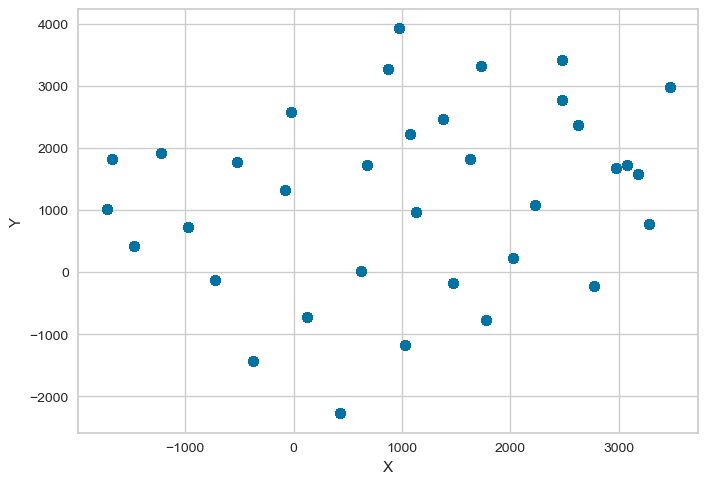

In [4]:
plt.scatter(well_data['X'], well_data['Y'])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

* We can also create a 3D plot to display the well location and the vertical distribution of facies

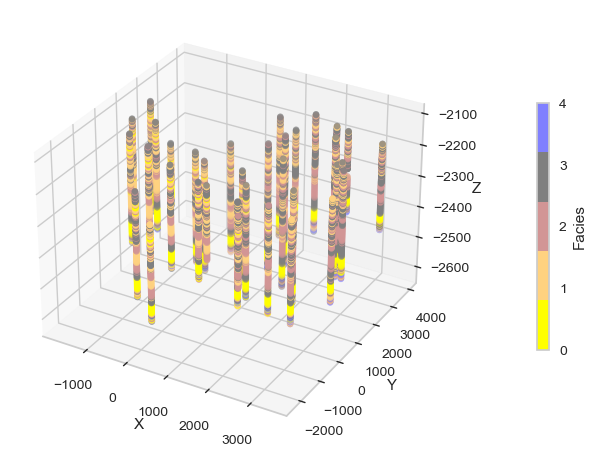

In [6]:
# Create a 3D scatter plot of x, y, and z
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

# Define facies colors
facies_colors_dict = {0: 'yellow', 1: '#FFD280', 2: '#D29595', 3: 'gray', 4: '#8080FF'}

# Assign facies colors to the data points
facies_colors = [facies_colors_dict[x] for x in well_data['Facies']]

# Create a ListedColormap with the custom colors
cmap = ListedColormap(list(facies_colors_dict.values()))

# Plot the data as a 3D scatter plot, using the custom colors
plot = ax.scatter(well_data['X'], well_data['Y'], well_data['Z'], c=well_data['Facies'], cmap=cmap)

# Create a colorbar with the custom colors and labels
cb = plt.colorbar(plot, shrink=0.4, pad=0.15, ticks=range(len(facies_colors_dict)))
cb.set_label('Facies')
cb.set_ticklabels(list(facies_colors_dict.keys()))

# Set labels for each axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## 🏁Step 4: Perform Exploratory Data Analysis (EDA) on the wells dataset

There are several transformations that you can apply to your well data to prepare it for machine learning:

1. Deal with missing values: If there are any missing values in the data, you can impute them using techniques such as mean imputation or k-nearest neighbor imputation.

2. Normalize or standardize the numerical features: You can scale the numerical features to have a similar range and distribution, such as using z-score normalization or min-max scaling. This can help prevent certain features from dominating the model's predictions.

3. Remove unnecessary columns: If any of the columns in your data are not relevant or redundant for the task at hand, you can remove them from the dataset to reduce noise and improve performance.

4. Create new features: You can engineer new features that may be more informative for the model, such as calculating gradients or derivatives of certain properties, or combining features in a meaningful way.

- First, check for missing values in the well data

In [7]:
# Check for missing values
print(well_data.isnull().sum())

X                       0
Y                       0
Z                       0
Seismic                 0
RAI                     0
Chaos                   0
Local Flatness          0
Sweetness               0
Distance From Faults    0
TVD                     0
I Cell                  0
J Cell                  0
K Cell                  0
Phi Krg Short           0
Phi Krg Long            0
Depo Type               0
Facies                  0
well name               0
dtype: int64


In [8]:
# Count occurrences of -99.00 in each column

np.count_nonzero(well_data == -99.00, axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

* Create a bar plot to show the distribution of the different facies in the well data

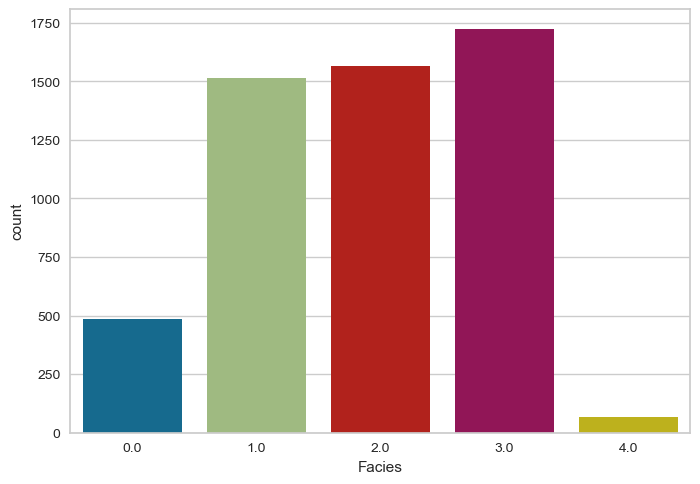

In [9]:
sns.countplot(x='Facies', data= well_data)
plt.show()

* Create a swarmplot and color the points according to the 'Facies' variable. To do that, we first need to melt and standardize the data 👇

In [10]:
# Create a copy of well_data
well_data_copy = well_data.copy()

# Randomly sample 2000 rows from the dataset
sampled_data = well_data_copy.sample(n=2000)

# Define the columns to include in the melted dataframe
columns = ['Seismic', 'RAI', 'Chaos',  'Local Flatness',  'Sweetness',  'Distance From Faults',  'TVD', 
           'I Cell',  'J Cell',  'K Cell',  'Phi Krg Short',  'Phi Krg Long']

# Standardize the selected columns, so that they have zero mean and unit variance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sampled_data[columns])

# Convert the scaled data to a dataframe
scaled_data = pd.DataFrame(scaled_data, columns=columns)

# Combine the standardized data with the non-scaled columns 'Facies' and 'well name'
scaled_data[['Facies', 'well name']] = sampled_data[['Facies', 'well name']]

# Melt the selected columns into a single column named 'variable'
melted_data = pd.melt(scaled_data, id_vars=['Facies'], 
                      value_vars=columns, var_name='variable')

# Visualize the melted dataframe
melted_data

,Facies,variable,value
0,NaN,Seismic,0.713618
1,NaN,Seismic,-0.039441
2,NaN,Seismic,-2.007916
3,NaN,Seismic,0.393438
4,3.0,Seismic,-1.568101
...,...,...,...
23995,3.0,Phi Krg Long,-0.458342
23996,NaN,Phi Krg Long,0.232969
23997,3.0,Phi Krg Long,-0.984658
23998,NaN,Phi Krg Long,0.088859


* We are now ready to build the swarm plot 😀 

💣 If we try to construct the plot for the entire dataset, it could take up to 60 minutes to generate. To avoid this lengthy process, we selected only 2000 rows when melting the data. However, if we do decide to use the entire dataset, it will appear similar to the image shown below 👇  

<img src="../images/Pic11.jpg" style="width: 1700px"/>

41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
40.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
49.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
70.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
42.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
52.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
36.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
51.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
42.4% of the points cannot be placed; you may want to d

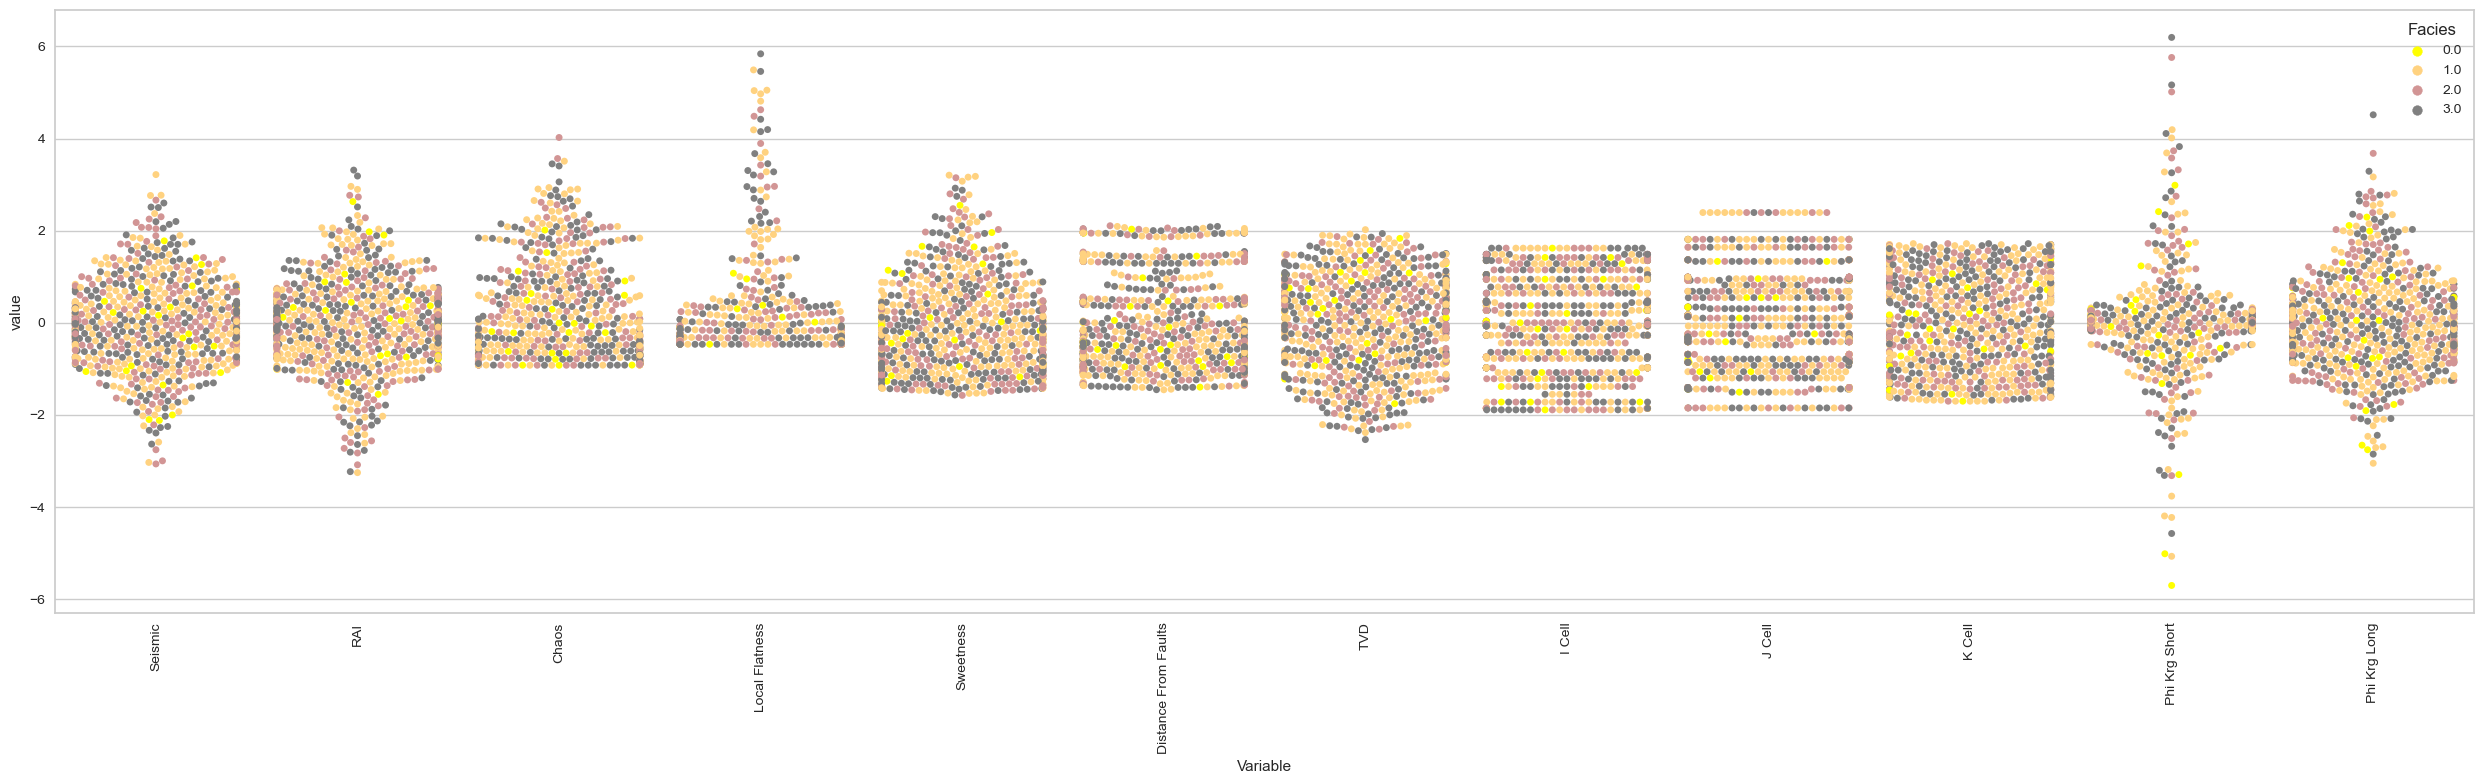

In [11]:
# Create a swarmplot and color the points according to the 'Facies' variable
plt.figure(figsize= (25, 8))
plt.xticks(rotation= 90)

# Create the swarm plot with Facies on the y-axis and the melted variables on the x-axis
sns.swarmplot(x='variable', y='value', hue= "Facies", data= melted_data, palette= facies_colors_dict, size= 5)

# Set the x-axis label and adjust the layout
plt.xlabel('Variable')
plt.tight_layout()
plt.show()

🧐 Take a moment to analyze the results displayed on this plot. Would you like to use all the input features on the facies prediction? 

## 🏁Step 5: Check for redundant or highly correlated features

* We can create a correlation matrix and visualize it as a heatmap

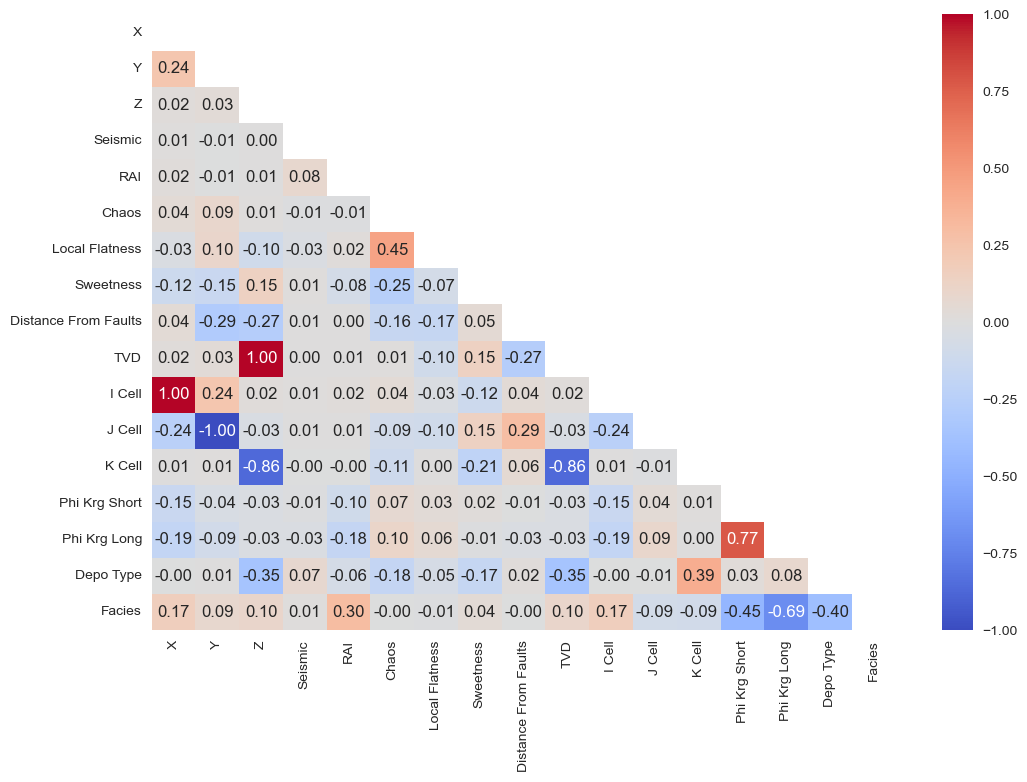

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

# Create correlation matrix
corr_matrix = well_data.corr()

# Create a boolean mask to mask the upper triangle of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the lower triangle of the matrix using a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', mask=mask)

plt.show()

✍ The correlation coefficient that is shown in the correlation matrix is the **Pearson correlation coefficient**, which measures the linear correlation between two variables. 

It ranges from -1 to 1, with 1 indicating a perfect positive correlation, 0 indicating no correlation, and -1 indicating a perfect negative correlation.

* We can also create a pairplot to analyze the relationships and distributions between multiple variables in a dataset 👇

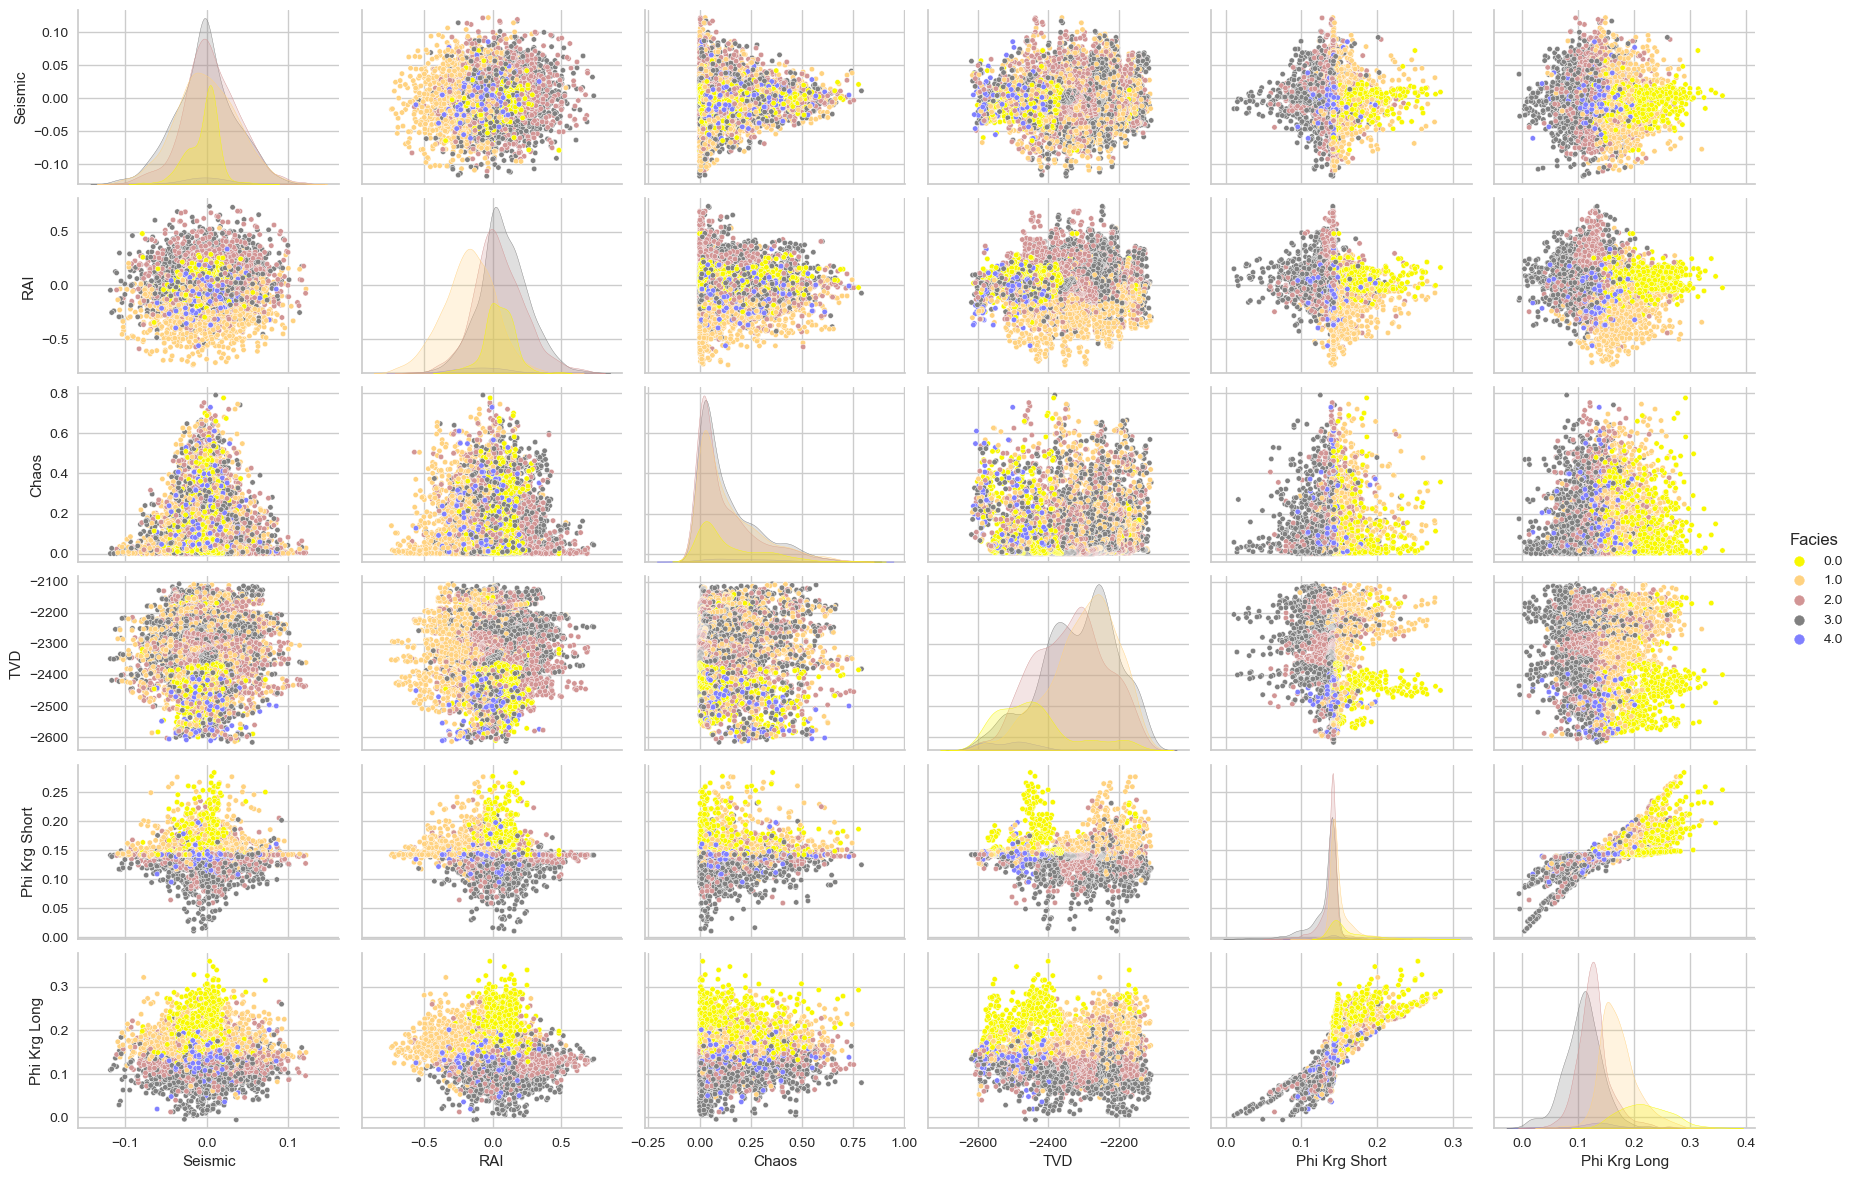

In [13]:
# Create a pairplot of selected variables using the Facies column to color the dots

facies_colors_dict = {0: '#F8F800', 1: '#FFD280', 2: '#D29595', 3: 'gray', 4: '#8080FF'}
custom_palette = sns.color_palette(list(facies_colors_dict.values()))

data = well_data[['Seismic', 'RAI' , 'Chaos', 'TVD', 'Phi Krg Short', 'Phi Krg Long', 'Facies']]

sns.pairplot(data= data, palette=custom_palette, hue='Facies', aspect= 1.5, height= 2, plot_kws={'s': 15})

* Another visualization option available is the parallel coordinates plot, which allows for the observation of patterns, correlations, and trends across multiple variables at once 👇

In [14]:
# Use plotly to create a parallel coordinates plot to visualize the correlation between those features

fig = px.parallel_coordinates(data_frame= sampled_data, 
                              dimensions=['Seismic', 'RAI' , 'Chaos', 'TVD', 'Phi Krg Long'], 
                              color= 'Facies')
fig.show()

❓ Which variable would be most efficient in classifying facies? 🧐

## 🏁Step 6: Import and explore the grid dataset

In [15]:
# load the csv file into a pandas dataframe
grid_data = pd.read_csv('../Data/facies_grid.csv')

# display 5 random rows of the dataframe
grid_data.sample(5)

,Seismic,RAI,Chaos,Local Flatness,Sweetness,Distance From Faults,TVD,I Cell,J Cell,K Cell,Phi Krg Short,Phi Krg Long,Depo Type,Facies,X,Y,Z
1659376,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.0,-99.000000
2924076,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.0,-99.000000
3142784,0.015132,0.196625,0.248216,0.005621,0.008199,190.772171,-2249.845947,129.0,44.0,74.0,0.138824,0.101526,1.0,3.0,3425.0,2775.0,-2249.845947
3618200,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.0,-99.000000
2381637,0.032560,0.248834,0.350768,0.144854,0.006400,313.022827,-2310.119385,94.0,132.0,100.0,0.141430,0.132668,2.0,2.0,1675.0,-1625.0,-2310.119385


In [16]:
grid_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Seismic,5241852.0,-53.361610,49.349200,-99.000000,-99.000000,-99.0,0.000000,1.196471
RAI,5241852.0,-53.363181,49.347690,-99.000000,-99.000000,-99.0,0.000000,5.617014
Chaos,5241852.0,-53.212627,49.510922,-99.000000,-99.000000,-99.0,0.120496,1.000000
Local Flatness,5241852.0,-53.327552,49.386131,-99.000000,-99.000000,-99.0,0.005396,0.953635
Sweetness,5241852.0,-53.358703,49.352339,-99.000000,-99.000000,-99.0,0.004875,0.249117
Distance From Faults,5241852.0,229.393062,478.716917,-99.000000,-99.000000,-99.0,441.794907,1891.020996
TVD,5241852.0,-1122.940016,1109.840975,-2624.527344,-2295.863586,-99.0,-99.000000,-99.000000
I Cell,5241852.0,-12.291940,97.673806,-99.000000,-99.000000,-99.0,82.000000,186.000000
J Cell,5241852.0,-21.305634,87.057524,-99.000000,-99.000000,-99.0,64.000000,154.000000
K Cell,5241852.0,-16.896022,94.023878,-99.000000,-99.000000,-99.0,72.000000,158.000000


## 🏁Step 7: Perform EDA on the grid dataset

In [17]:
# Count the number of missing values in each column
missing_values_count = grid_data.isna().sum()

# Print the result
print(missing_values_count)

Seismic                 0
RAI                     0
Chaos                   0
Local Flatness          0
Sweetness               0
Distance From Faults    0
TVD                     0
I Cell                  0
J Cell                  0
K Cell                  0
Phi Krg Short           0
Phi Krg Long            0
Depo Type               0
Facies                  0
X                       0
Y                       0
Z                       0
dtype: int64


In [18]:
# Count occurrences of -99.00 in each column

np.count_nonzero(grid_data == -99.00, axis=0)

array([2825393, 2825393, 2825393, 2825393, 2825393, 2825393, 2825393,
       2825393, 2825393, 2825393, 2825393, 2825393, 3370753, 3370753,
       2825393, 2825393, 2825393], dtype=int64)

In [19]:
# replace the null values (-99.00) with NaN and print the count of null values
grid_data = grid_data.replace(-99, np.nan)

grid_data.isna().sum()

Seismic                 2825393
RAI                     2825393
Chaos                   2825393
Local Flatness          2825393
Sweetness               2825393
Distance From Faults    2825393
TVD                     2825393
I Cell                  2825393
J Cell                  2825393
K Cell                  2825393
Phi Krg Short           2825393
Phi Krg Long            2825393
Depo Type               3370753
Facies                  3370753
X                       2825393
Y                       2825393
Z                       2825393
dtype: int64

* Create a bar plot to show the distribution of the different facies in the grid data

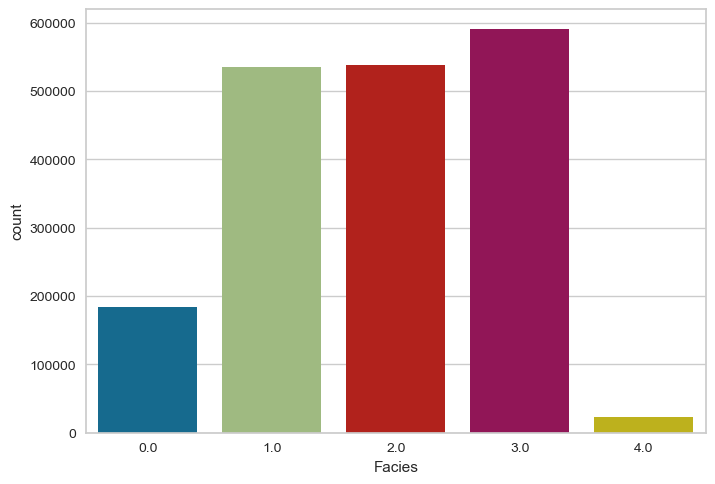

In [20]:
sns.countplot(x='Facies', data= grid_data)
plt.show()

## 🏁Step 8: Convert the pandas dataframe to numpy array

To be able to extract the facies "cube" from the entire grid, we need to convert the grid data from pandas dataframe to a numpy array.

This is the shape of the 3D grid data in Petrel:

- i = 186
- j = 154
- k = 183

In [21]:
# convert the dataframe to a 2D NumPy array
grid_arr = grid_data.to_numpy()

# Investigate the shape of the 2D array
grid_arr.shape

(5241852, 17)

* Now let's create a 1D numpy array containing the data for the Facies column. Based on the head of the pandas dataframe we know that the Facies data is stored in column 13

We need to perform some operations to transform the original 2D 'Facies' property into a reshaped, transposed, and flipped 3D array represented by Facies_3D. This transformation is useful for further analysis and visualization of the grid data

In [22]:
# Extract the 'Facies' column from the 2D array 'grid_arr' and assign it to the variable Facies
Facies = grid_arr[:, 13]

Facies.shape

(5241852,)

In [23]:
i = 186
j = 154
k = 183

# Reshape the the Facies property is reshaped into a 3D array to match the specified number of rows (k), columns (j), and depth (i)
facies_reshaped = Facies.reshape(k, j, i)

facies_reshaped.shape

(183, 154, 186)

In [24]:
# Use the transpose function to change the order of dimensions in the facies_reshaped array. This step is done to ensure the correct orientation of the data.
# By specifying (2, 1, 0), the dimensions are reordered to (i, j, k). 

Facies_3D = facies_reshaped.transpose((2, 1, 0))

Facies_3D.shape

(186, 154, 183)

💥 We can also merge the above two functions on a single line: Facies_3D = Facies.reshape(k, j, i).transpose((2, 1, 0))

## 🏁Step 9: Visualize a layer of the Facies Property

👉 We will create a map using the Facies data from the grid. The resulting image (map) will have one square for each element of the array

As we will continuously visualize multiple layers of the Facies grid and well data, let's create a plotting function 👇

In [25]:
def plot_layer_wells(z, layer_data, well_data, grid_name):

    """
    Plots a 2D layer of a 3D grid along with the locations of wells

    Arguments:
    - layer_data (numpy.ndarray): A 3D numpy array representing the facies grid.
    - well_data (pandas.DataFrame): A pandas dataframe containing the X, Y, Z, I, J, and well name info for each well.
    - z (int): The index of the layer to plot.
    - grid_name: string, the name of the grid being plotted

    Example usage:
    >>> plot_layer_wells( z=115, layer_data=Facies_3D, well_data=well_data, grid_name='Facies_3D')

    """

    # Define the dictionary mapping values to colors
    facies_colors_dict = {0: '#F8F800', 1: '#FFD280', 2: '#D29595', 3: 'gray', 4: '#8080FF'}

    # Define the custom colormap using the dictionary
    facies_colors = ListedColormap([facies_colors_dict[i] for i in range(len(facies_colors_dict))])

    # Flip the grid along the y-axis
    grid_to_plot = np.flip(layer_data, axis=1)

    # Get the 2D array for the specified layer and transpose it
    z_layer = grid_to_plot[:, :, z].T

    # Create a 2D plot of the layer
    im = plt.imshow(z_layer, cmap=facies_colors, origin='lower', vmin=0, vmax=4)

    # Add scatter points for the well locations
    plt.scatter(well_data['I Cell'], well_data['J Cell'], c='red', marker='P', label=well_data['well name'])

    # Legend
    cbar = plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04, ticks=[0, 1, 2, 3, 4])
    cbar.set_label(f'{grid_name}', rotation=90)

    # Axis labels
    plt.xlabel('j axis')
    plt.ylabel('i axis')
    plt.gca().invert_yaxis()

    # Title
    plt.title(f"Z = {z}", fontweight="bold", loc='center')

    # Show the plot
    plt.show()

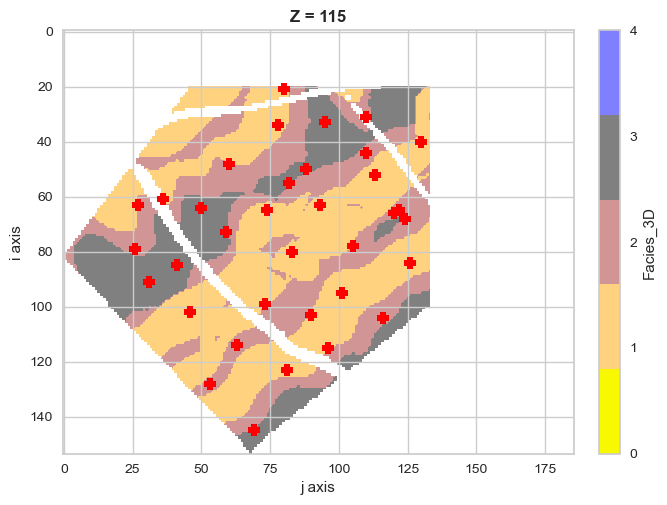

In [26]:
plot_layer_wells(115, Facies_3D, well_data, 'Facies_3D')

----------------------------------------

# PART 2 - Train a ML model using the well data

## 🏁Step 10: Define the target and feature variables

In [27]:
well_data.columns

Index(['X', 'Y', 'Z', 'Seismic', 'RAI', 'Chaos', 'Local Flatness', 'Sweetness',
       'Distance From Faults', 'TVD', 'I Cell', 'J Cell', 'K Cell',
       'Phi Krg Short', 'Phi Krg Long', 'Depo Type', 'Facies', 'well name'],
      dtype='object')

In [28]:
# Define the target variable, in this case -> Facies
target = well_data['Facies']

In [29]:
# Define the feature variables to be used in the model
features = well_data[['Seismic', 'RAI', 'Chaos', 'Local Flatness', 'Sweetness',
       'TVD', 'I Cell', 'J Cell', 'K Cell', 'Depo Type']]

## 🏁Step 11: Split the well data into train and test sets

In [30]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,
                                                    stratify= target, random_state=123)

👆 The 'stratify' parameter ensures that the split is stratified according to the target variable. This means that the proportion of each class in the training and testing datasets will be the same as the proportion in the original dataset

To verify that the stratify argument in the train_test_split() function has indeed stratified the data, you can compare the distribution of the target variable (y) in the original dataset and the training/testing sets.

In [31]:
target.value_counts(normalize=True)

3.0    0.321449
2.0    0.292514
1.0    0.282434
0.0    0.090909
4.0    0.012694
Name: Facies, dtype: float64

In [32]:
y_train.value_counts(normalize=True)

3.0    0.321354
2.0    0.292649
1.0    0.282380
0.0    0.091015
4.0    0.012602
Name: Facies, dtype: float64

In [33]:
y_test.value_counts(normalize=True)

3.0    0.321828
2.0    0.291978
1.0    0.282649
0.0    0.090485
4.0    0.013060
Name: Facies, dtype: float64

## 🏁Step 12: Train and evaluate some ML models

In [49]:
# Create a decision tree classifier
dt = DecisionTreeClassifier(random_state=123)

# Train the classifier using the training data
dt.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_dt = dt.predict(X_test)

# Classification report for the model trained using DecisionTreeClassifier
report_dt = classification_report(y_test, y_pred_dt)
print(report_dt)

              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83        97
         1.0       0.69      0.72      0.70       303
         2.0       0.67      0.67      0.67       313
         3.0       0.71      0.72      0.71       345
         4.0       0.25      0.14      0.18        14

    accuracy                           0.70      1072
   macro avg       0.64      0.60      0.62      1072
weighted avg       0.70      0.70      0.70      1072



In [50]:
# Create a random forest classifier object
rf = RandomForestClassifier(random_state=123)

# Train the random forest model using the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = rf.predict(X_test)

# Classification report for the model trained using rf
report_rf = classification_report(y_test, y_pred_rf)
print(report_rf)

              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87        97
         1.0       0.71      0.79      0.75       303
         2.0       0.78      0.68      0.73       313
         3.0       0.76      0.81      0.78       345
         4.0       0.45      0.36      0.40        14

    accuracy                           0.76      1072
   macro avg       0.73      0.69      0.71      1072
weighted avg       0.77      0.76      0.76      1072



In [51]:
# Create an XGBClassifier object
xgb = xgb.XGBClassifier(random_state=123)

# Train the xgb model using the training data
xgb.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_xgb = xgb.predict(X_test)

# Classification report for the model trained using xgb
report_xgb = classification_report(y_test, y_pred_xgb)
print(report_xgb)

              precision    recall  f1-score   support

         0.0       0.93      0.89      0.91        97
         1.0       0.74      0.79      0.77       303
         2.0       0.84      0.70      0.77       313
         3.0       0.76      0.86      0.81       345
         4.0       0.45      0.36      0.40        14

    accuracy                           0.79      1072
   macro avg       0.75      0.72      0.73      1072
weighted avg       0.79      0.79      0.79      1072



In [53]:
# Create an LGBMClassifier object
lgbm = LGBMClassifier(random_state=123)

# Train the lgbm model using the training data
lgbm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_lgbm = lgbm.predict(X_test)

# Classification report for the model trained using lgbm
report_lgbm = classification_report(y_test, y_pred_lgbm)
print(report_lgbm)

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94        97
         1.0       0.77      0.79      0.78       303
         2.0       0.81      0.70      0.75       313
         3.0       0.76      0.88      0.81       345
         4.0       0.43      0.21      0.29        14

    accuracy                           0.79      1072
   macro avg       0.75      0.70      0.71      1072
weighted avg       0.79      0.79      0.79      1072



## 🏁Step 13: Evaluate the performance of the models using cross-validation

The primary purpose of cross-validation is to provide an unbiased estimate of the model's performance on new and unseen data, without having to set aside a separate validation set. This can be particularly useful when the amount of data is limited, or when the data is highly variable.

### Cross Validation for Desicion Tree Model

In [54]:
# Use cross-validation to estimate model performance for Decision Tree Classifier
scores_dt = cross_val_score(dt, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Decision Tree Classifier Cross-validation scores:", scores_dt)

# Compute the mean of the cross-validation scores
mean_score = scores_dt.mean()
print("Mean cross-validation score:", mean_score)

Decision Tree Classifier Cross-validation scores: [0.68844807 0.68494749 0.67677946 0.6907818  0.66277713]
Mean cross-validation score: 0.6807467911318553


📌 For classification problems, the default evaluation metric used by cross_val_score is the accuracy, which represents the proportion of correctly classified samples

### Cross Validation for Random Forest Model

In [55]:
# Use cross-validation to estimate model performance for Random Forest
scores_rf = cross_val_score(rf, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Random Forest Cross-validation scores:", scores_rf)

# Compute the mean of the cross-validation scores
mean_score = scores_rf.mean()
print("Mean cross-validation score:", mean_score)

Random Forest Cross-validation scores: [0.7327888  0.74912485 0.70595099 0.75029172 0.76312719]
Mean cross-validation score: 0.7402567094515753


### Cross Validation for XGB Model

In [56]:
# Use cross-validation to estimate model performance for XGBoost
scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5)

# Print the cross-validation scores
print("XGBoost Cross-validation scores:", scores_xgb)

# Compute the mean of the cross-validation scores
mean_score = scores_xgb.mean()
print("Mean cross-validation score:", mean_score)

XGBoost Cross-validation scores: [0.76079347 0.77712952 0.74679113 0.76429405 0.76779463]
Mean cross-validation score: 0.7633605600933488


### Cross Validation for LGBM Model

In [57]:
# Use cross-validation to estimate model performance for LightGBM
scores_lgbm = cross_val_score(lgbm, X_train, y_train, cv=5)

# Print the cross-validation scores
print("LightGBM Cross-validation scores:", scores_lgbm)

# Compute the mean of the cross-validation scores
mean_score = scores_lgbm.mean()
print("Mean cross-validation score:", mean_score)

LightGBM Cross-validation scores: [0.74679113 0.77362894 0.74562427 0.77129522 0.77012835]
Mean cross-validation score: 0.7614935822637106


## 🏁Step 14: Compare the cross validation results for different models

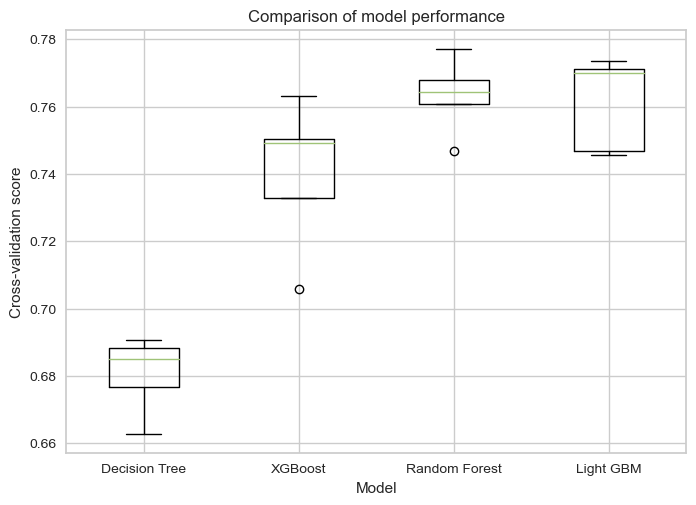

In [58]:
# create a figure and axis object
fig, ax = plt.subplots()

# plot the box plots
ax.boxplot([scores_dt, scores_rf, scores_xgb, scores_lgbm], 
           labels=['Decision Tree', 'XGBoost', 'Random Forest', 'Light GBM'])

# set the axis labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Cross-validation score')
ax.set_title('Comparison of model performance')

# show the plot
plt.show()

## 🏁Step 15: Evaluate the best model with a confusion matrix

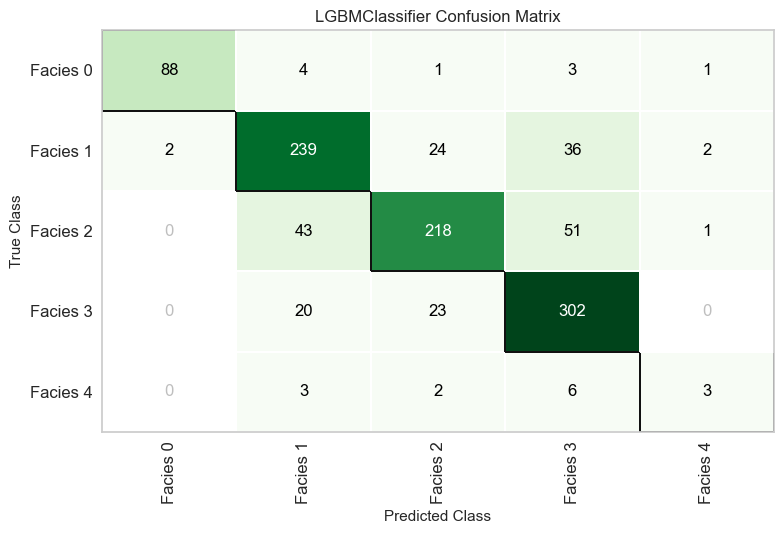

<AxesSubplot:title={'center':'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [59]:
# Define the class names
class_names = ["Facies 0", "Facies 1", "Facies 2", "Facies 3", "Facies 4"]

# Create a ConfusionMatrix visualizer
cm = ConfusionMatrix(lgbm, classes=class_names, cmap='Greens')

# Fit the visualizer to the training data
cm.fit(X_train, y_train)

# Evaluate the model on the test data
cm.score(X_test, y_test)

# Draw the confusion matrix
cm.show()

## 🏁Step 16: Hyperparameter tunning using GridSearch

Explanation of the parameters:

**n_estimators**: This parameter controls the number of trees in the ensemble. 

**max_depth**: This parameter determines the maximum depth of each tree.

**min_child_samples**: This parameter sets the minimum number of samples required to form a new leaf node. It can help control the tree growth and prevent overfitting. A larger value can lead to simpler trees, but too high a value may result in underfitting

In [60]:
# define the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 500], 'max_depth': [5, 10, None], 'min_child_samples': [5, 10, 20]}

# create the grid search object
grid_search = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1)

# fit the grid search object to the data
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_
print("Best lgbm hyperparameters:", best_params)
print("Train accuracy:", grid_search.best_score_)
print("Test accuracy:", grid_search.score(X_test, y_test))

## 🏁Step 17: Hyperparameter tunning using RandomizedSearchCV

🧩 **best_params** tells you the values of the hyperparameters that led to the best performance during the grid search

In [61]:
# Define the parameter grid to search over
param_dist = {'n_estimators': [100, 200, 500, 1000], 'max_depth': [5, 10, 20, None], 'min_child_samples': [5, 10, 20, 50]}

# Perform a randomized search for the LightGBM model
random_search = RandomizedSearchCV(lgbm, param_dist, n_iter=5, cv=5, n_jobs=-1)

# Fit the randomized search to the training data
random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Train accuracy: {random_search.best_score_}")
print(f"Test accuracy: {random_search.score(X_test, y_test)}")

Best parameters: {'n_estimators': 100, 'min_child_samples': 5, 'max_depth': 10}
Train accuracy: 0.7666277712952159
Test accuracy: 0.7854477611940298


✍ n_jobs parameter controls the number of CPU cores to use for parallel processing. Setting it to -1 means that all available CPU cores will be used to perform the computation in parallel.

## 🏁Step 18: Visualize a confusion matrix for a tunned model

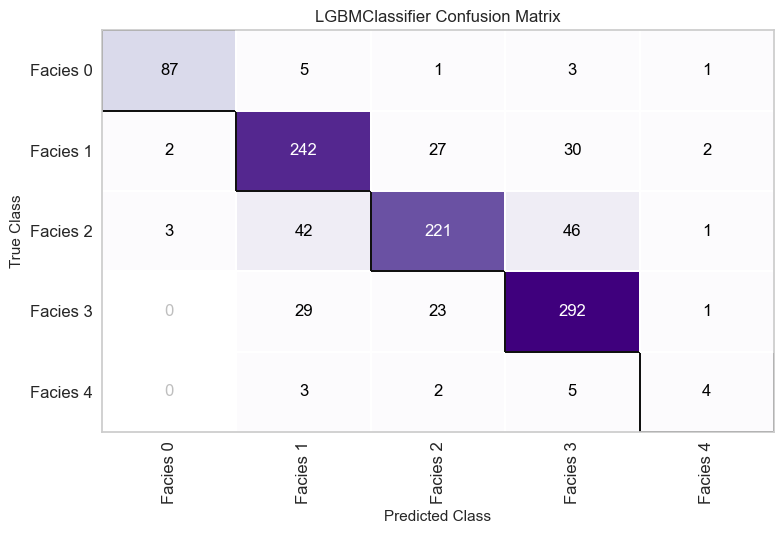

<AxesSubplot:title={'center':'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [62]:
# Train the model using the best hyperparameters from the gridsearch
lgbm_tun = LGBMClassifier(max_depth= None, min_child_samples= 5, n_estimators= 500)

# Define the class names
class_names = ["Facies 0", "Facies 1", "Facies 2", "Facies 3", "Facies 4"]

# Create a ConfusionMatrix visualizer
cm = ConfusionMatrix(lgbm_tun, classes=class_names, cmap='Purples')

# Fit the visualizer with the test data
cm.fit(X_train, y_train)

# Evaluate the model on the test data
cm.score(X_test, y_test)

# Draw the confusion matrix
cm.show()

🤓 Let's compare the confusion matrix of the LGBM model before and after the hyperparameter tuning process

## 🏁Step 19: Understanding the ML model using SHAP

In [63]:
features.sample(5)

,Seismic,RAI,Chaos,Local Flatness,Sweetness,TVD,I Cell,J Cell,K Cell,Depo Type
3375,-0.01632,-0.73070,0.0177,0.0019,0.01810,-2293.20,27.0,63.0,98.0,2.0
2533,0.05100,0.08149,0.1335,0.1660,0.00854,-2407.56,74.0,65.0,73.0,1.0
4934,-0.01431,0.10327,0.0774,0.0007,0.00496,-2436.18,46.0,102.0,146.0,2.0
3822,0.02660,-0.06818,0.2030,0.4355,0.00645,-2421.43,116.0,104.0,112.0,2.0
2422,-0.03958,0.33993,0.1214,0.0133,0.00872,-2264.96,31.0,91.0,70.0,1.0


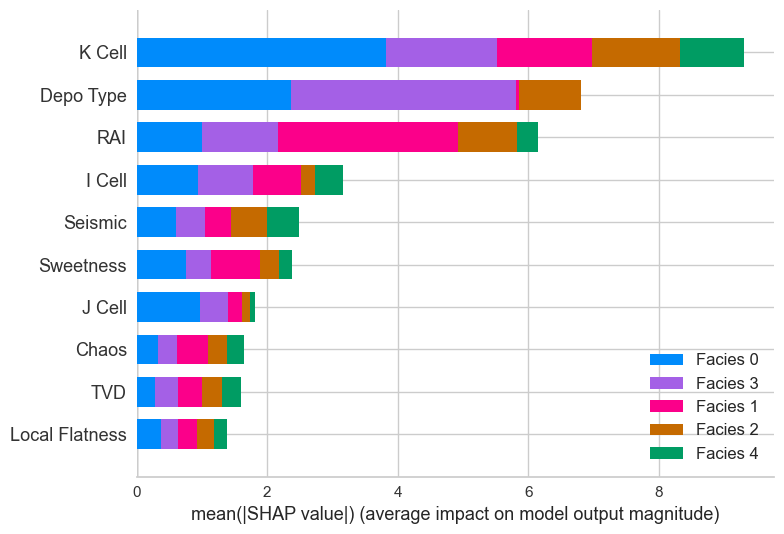

In [64]:
# Create the summary plot using the SHAP values object

explainer = shap.Explainer(lgbm_tun)
shap_values = explainer.shap_values(features)
shap.summary_plot(shap_values, features, class_names=class_names)

#  PART 3 - Predict on the grid data

## 🏁Step 20: Prepare the grid data for prediction

The features in the seismic data (grid_data) and the well data (X_test) must be in the same order for the XGBoost model to make accurate predictions

We need to adjust the order of the columns on the grid to match the order of the columns on the well data

To do this we can use the .reindex() function

In [65]:
grid_data.sample(5)

,Seismic,RAI,Chaos,Local Flatness,Sweetness,Distance From Faults,TVD,I Cell,J Cell,K Cell,Phi Krg Short,Phi Krg Long,Depo Type,Facies,X,Y,Z
41529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4735119,-0.084592,-0.226454,0.00510,0.002368,0.019324,812.376953,-2254.75415,118.0,107.0,18.0,0.141430,0.142362,1.0,1.0,2875.0,-375.0,-2254.75415
1401378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3002157,-0.006635,0.154889,0.28788,0.306361,0.002027,191.520126,-2246.19458,118.0,30.0,79.0,0.138148,0.117092,1.0,3.0,2875.0,3475.0,-2246.19458
3884811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
grid_data['Facies'].unique()

array([nan,  3.,  2.,  4.,  1.,  0.])

* It's important to make sure that the columns in the grid data are named and ordered just like they are in the well data 🤓

In [67]:
well_data.columns

Index(['X', 'Y', 'Z', 'Seismic', 'RAI', 'Chaos', 'Local Flatness', 'Sweetness',
       'Distance From Faults', 'TVD', 'I Cell', 'J Cell', 'K Cell',
       'Phi Krg Short', 'Phi Krg Long', 'Depo Type', 'Facies', 'well name'],
      dtype='object')

In [68]:
grid_data.columns

Index(['Seismic', 'RAI', 'Chaos', 'Local Flatness', 'Sweetness',
       'Distance From Faults', 'TVD', 'I Cell', 'J Cell', 'K Cell',
       'Phi Krg Short', 'Phi Krg Long', 'Depo Type', 'Facies', 'X', 'Y', 'Z'],
      dtype='object')

In [69]:
# Select all columns in well_data except for well name
well_cols = list(well_data.columns.drop(['well name']))

# Reorder columns in grid_data to match well_cols
grid_data = grid_data.reindex(columns= well_cols)
grid_data.sample(5)

,X,Y,Z,Seismic,RAI,Chaos,Local Flatness,Sweetness,Distance From Faults,TVD,I Cell,J Cell,K Cell,Phi Krg Short,Phi Krg Long,Depo Type,Facies
561050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1635051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4951767,775.0,3975.0,-2256.140625,0.0,0.0,0.298552,4.697230e-01,0.0,215.650787,-2256.140625,76.0,20.0,11.0,0.142394,0.191283,NaN,NaN
1273411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2139357,5575.0,2525.0,-2203.819824,0.0,0.0,1.000000,-2.220446e-16,0.0,1552.176025,-2203.819824,172.0,49.0,109.0,0.142251,0.142117,NaN,NaN


## 🏁Step 21: Select the features to be included in the prediction

🔑 It is crucial to select the exact same variables from grid data that were utilized to train the model from well data

In [70]:
# Select the same variables used to train the model with the well data

grid_data_feat = grid_data[['Seismic', 'RAI', 'Chaos', 'Local Flatness', 'Sweetness',
       'TVD', 'I Cell', 'J Cell', 'K Cell', 'Depo Type']]

grid_data_feat.sample(5)

,Seismic,RAI,Chaos,Local Flatness,Sweetness,TVD,I Cell,J Cell,K Cell,Depo Type
1492555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1897245,-0.026671,-0.156769,0.032607,0.006470,0.004890,-2400.804688,46.0,118.0,117.0,2.0
4333836,-0.035582,-0.233619,0.056215,0.000830,0.011396,-2226.057617,37.0,108.0,32.0,2.0
4933523,0.030894,0.297796,0.004170,0.000437,0.010647,-2166.325195,60.0,118.0,11.0,1.0
3947216,-0.035759,-0.066805,0.194581,0.027744,0.007941,-2218.795166,111.0,31.0,46.0,2.0


## 🏁Step 22:  Dealing with the null values in the grid data

In [71]:
# Filter the rows where the Depo Type is either 1 or 2. This indicates that we have Facies and feature values for those specific rows
grid_data_feat = grid_data_feat[(grid_data_feat['Depo Type'] == 1) | (grid_data_feat['Depo Type'] == 2)]

# Reset the index of the filtered DataFrame
grid_data_feat = grid_data_feat.reset_index(drop=True)

grid_data_feat

,Seismic,RAI,Chaos,Local Flatness,Sweetness,TVD,I Cell,J Cell,K Cell,Depo Type
0,0.013031,-0.053196,0.352925,0.176319,0.003247,-2559.645508,68.0,154.0,158.0,2.0
1,0.015694,-0.071424,0.562499,0.291425,0.004009,-2556.846436,69.0,154.0,158.0,2.0
2,0.041264,-0.099199,0.280251,0.045248,0.008511,-2559.148193,67.0,153.0,158.0,2.0
3,0.025245,-0.109220,0.318699,0.060837,0.006229,-2556.292480,68.0,153.0,158.0,2.0
4,0.019718,-0.110570,0.509565,0.123838,0.005530,-2553.460693,69.0,153.0,158.0,2.0
...,...,...,...,...,...,...,...,...,...,...
1871094,-0.005120,-0.029258,0.499101,0.227382,0.002553,-2111.980957,130.0,21.0,1.0,1.0
1871095,-0.002867,0.012145,0.580173,0.240261,0.001292,-2108.166260,131.0,21.0,1.0,1.0
1871096,-0.002891,-0.006141,0.572500,0.317719,0.001447,-2104.485352,132.0,21.0,1.0,1.0
1871097,-0.004653,0.009407,0.543996,0.360731,0.001201,-2100.993652,133.0,21.0,1.0,1.0


By resetting the index, you obtain a DataFrame with a clean, sequential index that reflects the new structure or transformations applied to the data. This can be helpful for further analysis or when merging/joining data with other DataFrames that expect a consistent index structure

## 🏁Step 23: Predict using the previously trained LGBM model

In [72]:
# Make predictions only on the filtered data using the tunned LGBM model
y_pred = lgbm_tun.predict(grid_data_feat)

## 🏁Step 24: Evaluate the performance of the LGBM model on the grid data

In [73]:
# Create a new array named y_true and assign it the values from the 'Facies' column of the grid_data
y_true = grid_data['Facies']

In [74]:
# Create a new variable named y_true and assign it the values from the 'Facies' column of the grid_data
y_true = grid_data['Facies']

# filter the y_true array to include only rows where the corresponding 'Depo Type' column in the grid_data DataFrame is either 1 or 2
y_true_filter = y_true[(grid_data['Depo Type'] == 1) | (grid_data['Depo Type'] == 2)]

# Calculate precision, recall, and F1 score for the the predicted values (y_pred) compared to the filtered ground truth labels (y_true_filter)
precision = precision_score(y_true_filter, y_pred, average='weighted')
recall = recall_score(y_true_filter, y_pred, average='weighted')
f1 = f1_score(y_true_filter, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Precision: 0.7988057901256997
Recall: 0.796296721873081
F1 score: 0.7949574655549776


💥 The line 5 in the code above achieves the matching of elements between y_true and grid_data based on the index alignment

## 🏁Step 25: Plot the confusion matrix for the LGBM model on the grid data

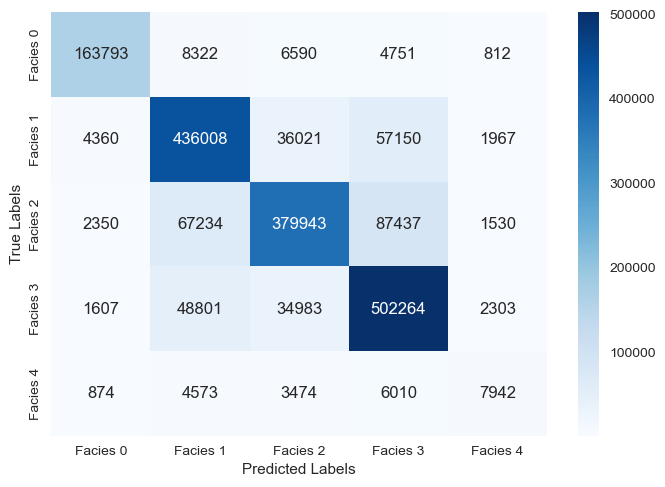

In [75]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_true_filter, y_pred)

# Define the class names
class_names = ["Facies 0", "Facies 1", "Facies 2", "Facies 3", "Facies 4"]

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 🏁Step 26: Add the predicted Facies back to the original grid

In [76]:
# Add a new column for the predicted facies labels and initialize it with NaN (missing) values
grid_data['Facies_pred'] = np.nan

# Update the values in the 'Facies_pred' column of the grid_data with the corresponding values from  y_pred
grid_data.loc[(grid_data['Depo Type'] == 1) | (grid_data['Depo Type'] == 2), 'Facies_pred'] = y_pred

grid_data.shape

(5241852, 18)

In [77]:
grid_data.sample(5)

,X,Y,Z,Seismic,RAI,Chaos,Local Flatness,Sweetness,Distance From Faults,TVD,I Cell,J Cell,K Cell,Phi Krg Short,Phi Krg Long,Depo Type,Facies,Facies_pred
4202504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3141479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3794524,3225.0,875.0,-2277.331299,0.009835,0.142384,0.369955,0.063953,0.003028,908.933167,-2277.331299,125.0,82.0,51.0,0.141430,0.178212,1.0,1.0,3.0
3861736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2552563,1275.0,-1875.0,-2316.831543,0.004447,-0.033040,0.269482,0.020927,0.005168,696.752441,-2316.831543,86.0,137.0,94.0,0.141377,0.135633,2.0,2.0,2.0


In [78]:
# convert the dataframe to a NumPy array
grid_pred = grid_data.to_numpy()
grid_pred.shape

(5241852, 18)

## 🏁Step 27:  Create a 3D array using the predicted Facies

In [79]:
# extract the 'predicted_facies' column from the 2D array 'grid_pred'
Facies_pred = grid_pred[:, 17]
Facies_pred.shape

(5241852,)

In [80]:
i = 186
j = 154
k = 183

# Reshape the the Facies property is reshaped into a 3D array to match the specified number of rows (k), columns (j), and depth (i)
facies_reshaped = Facies_pred.reshape(k, j, i)
print(facies_reshaped.shape)

# Use the transpose function to change the order of dimensions in the facies_reshaped array. 
Facies_3D_pred = facies_reshaped.transpose((2, 1, 0))
print(Facies_3D.shape)

(183, 154, 186)
(186, 154, 183)


In [81]:
np.unique(Facies_3D_pred)

array([ 0.,  1.,  2.,  3.,  4., nan])

## 🏁Step 28: Compare the distribution of actual versus predicted Facies

Now let's define a new plotting function to compare the actual versus predicted results 👇

In [96]:
def plot_layers_wells(z, layer_data, layer_data_pred, well_data, grid_name):

    """
    Plots a 2D layer of a geological grid along with the locations of wells on the layer.

    Arguments:
    - layer_data (numpy.ndarray): A 3D numpy array representing the actual Facies grid
    - layer_data_pred (numpy.ndarray): A 3D numpy array representing the predicted Facies grid
    - well_data (pandas.DataFrame): A pandas dataframe containing the coordinates and well name for each well.
    - z (int): The index of the layer to plot.
    - grid_name: string, the name of the grid being plotted

    Example usage:
    >>> plot_layer_wells(z=115, layer_data=Facies_3D, layer_data_pred=Facies_3D_pred, well_data=well_data, grid_name='Facies_3D')

    """

    # Define the dictionary mapping values to colors
    facies_colors_dict = {0: '#F8F800', 1: '#FFD280', 2: '#D29595', 3: 'gray', 4: '#8080FF'}

    # Define the custom colormap using the dictionary
    facies_colors = ListedColormap([facies_colors_dict[i] for i in range(len(facies_colors_dict))])

    # Flip the grids along the y-axis
    grid_to_plot = np.flip(layer_data, axis=1)
    grid_to_plot_pred = np.flip(layer_data_pred, axis=1)

    # Get the 2D arrays for the specified layer and transpose them
    z_layer = grid_to_plot[:, :, z].T
    z_layer_pred = grid_to_plot_pred[:, :, z].T

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    # Plot the actual data on the left subplot
    im1 = ax1.imshow(z_layer, cmap=facies_colors, origin='lower', vmin=0, vmax=4)
    ax1.scatter(well_data['I Cell'], well_data['J Cell'], c='red', marker='P', label=well_data['well name'])
    ax1.set_xlabel('j axis')
    ax1.set_ylabel('i axis')
    ax1.invert_yaxis()
    ax1.set_title(f"Actual {grid_name} (Z = {z})", fontweight="bold", loc='center')

    # Plot the predicted data on the right subplot
    im2 = ax2.imshow(z_layer_pred, cmap=facies_colors, origin='lower', vmin=0, vmax=4)
    ax2.scatter(well_data['I Cell'], well_data['J Cell'], c='red', marker='P', label=well_data['well name'])
    ax2.set_xlabel('j axis')
    ax2.set_ylabel('i axis')
    ax2.invert_yaxis()
    ax2.set_title(f"Predicted {grid_name} (Z = {z})", fontweight="bold", loc='center')

    # Add a colorbar
    cbar = fig.colorbar(im1, ax=[ax1, ax2], pad=0.04, fraction = 0.02, ticks=[0, 1, 2, 3, 4])
    cbar.ax.set_yticklabels(['Facies 0', 'Facies 1', 'Facies 2', 'Facies 3', 'Facies 4'])

    plt.show()

We can use the plotting function to plot an specific layer 👇

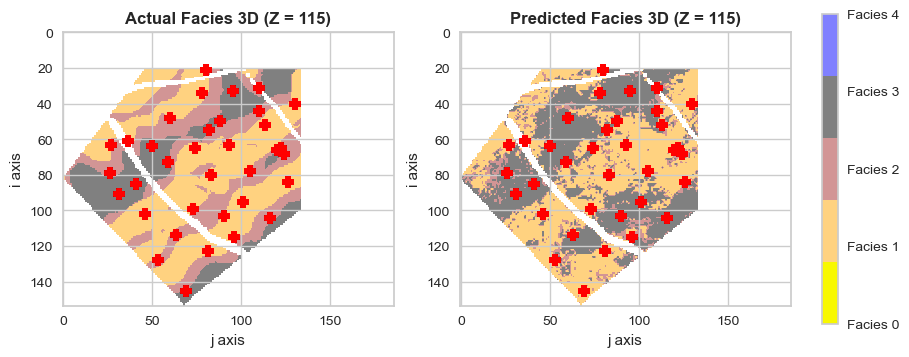

In [97]:
plot_layers_wells(115, Facies_3D, Facies_3D_pred, well_data, 'Facies 3D')

Or we can use the plotting function to plot three random layers from the grid 👇

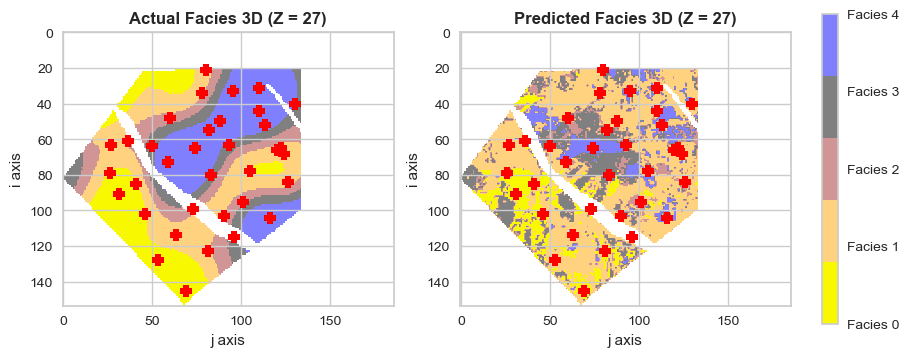

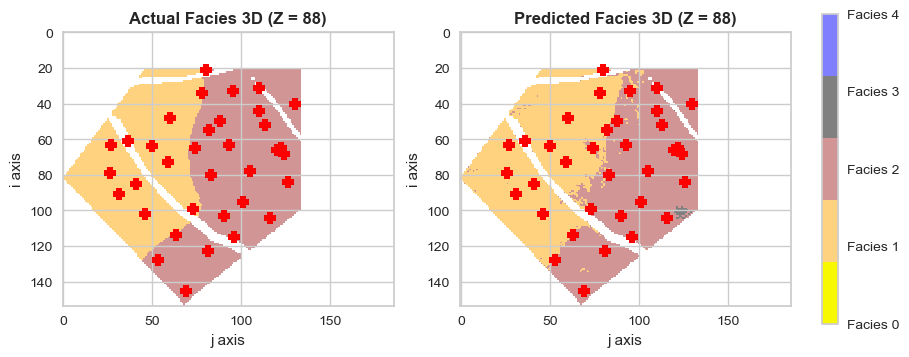

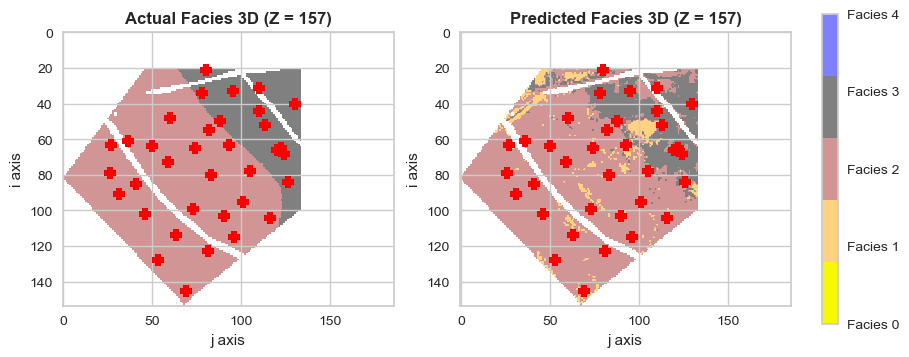

In [98]:
import random
# Set the range of layers
z_min = 25
z_max = 182

# Randomly select 3 layers
random_layers = random.sample(range(z_min, z_max+1), 3)

# Loop through the selected layers and plot each layer
for z in random_layers:
    plot_layers_wells(z=z, layer_data=Facies_3D, layer_data_pred=Facies_3D_pred, well_data=well_data, grid_name='Facies 3D') 

🎯 Well done!

@scienclick Thanks!!!